In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarcasm2/sarcasm_dataset.json
/kaggle/input/contractions/contractions.csv


In [2]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, TFAutoModel
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModel
from sklearn.metrics import classification_report

In [3]:
data = pd.read_json("../input/sarcasm2/sarcasm_dataset.json", lines=True)
data

,is_sarcastic,headline
0,1,It feels like just a few days ago it was the l...
1,1,"I love my mom . No matter what we go through ,..."
2,1,Bump that music ... #imtryingtosleep #sarcasm
3,0,Mexican and black jokes are pretty much the sa...
4,0,How to find work you love :
...,...,...
54926,0,Don't be so formal because I'm much older you ...
54927,0,Busy night in work ... She esh ! Bed now then ...
54928,0,yayyy Avicii u haz a new song <3 OMG I can't w...
54929,0,""" you th i nk i'm shit . Well , you're wrong ...."


In [12]:
import re
# Load contractions
contractions = pd.read_csv('/kaggle/input/contractions/contractions.csv', index_col='Contraction', encoding='latin-1')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Define regex patterns
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"  # URLs
userPattern       = '@[^\s]+'                                        # @USERNAME
hashtagPattern    = r'#\S+'                                          # Hashtags
sequencePattern   = r"(.)\1\1+"                                      # Consecutive letters
seqReplacePattern = r"\1\1"                                          # Replace long sequences


# Preprocessing function
def preprocess_apply(tweet):
    tweet = tweet.lower()

    # Remove URLs
    tweet = re.sub(urlPattern, '', tweet)
    # Remove @USERNAME mentions
    tweet = re.sub(userPattern, '', tweet)
    # Remove hashtags and their names
    tweet = re.sub(hashtagPattern, '', tweet)
    # Replace 3+ consecutive letters by 2 letters
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace contractions
    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Add spaces around slashes
    tweet = re.sub(r'/', ' / ', tweet)

    return tweet.strip()

In [13]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def preprocess(tweet, stem=True):
    tweet = re.sub(text_cleaning_re, ' ', str(tweet).lower()).strip()
    tokens = []
    for token in tweet.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [15]:
data['processed_text'] = data.headline.apply(preprocess_apply)
data['processed_text'] = data.headline.apply(preprocess)

In [16]:
labels = data.is_sarcastic.values
sentences = data.processed_text.values

In [17]:
# Load BERTweet tokenizer and model
PRE_TRAINED_MODEL_NAME = 'vinai/bertweet-base'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, use_fast=False)

# Sentence encoding function for BERTweet
def encoder(sentences, max_length=16):
    ids = []
    for sentence in sentences:
        encoding = tokenizer.encode_plus(
            sentence,
            max_length=max_length,
            truncation=True,
            add_special_tokens=True,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=False
        )
        ids.append(encoding['input_ids'])
    return ids

In [18]:
# Split the data
train_sents, test_sents, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.15)

# Encode sentences
train_ids = encoder(train_sents)
test_ids = encoder(test_sents)
train_ids = tf.convert_to_tensor(train_ids)
test_ids = tf.convert_to_tensor(test_ids)
train_labels = tf.convert_to_tensor(train_labels)
test_labels = tf.convert_to_tensor(test_labels)

# Load BERTweet model
bertweet_model = TFAutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [19]:
# Build the model architecture
input_word_ids = tf.keras.Input(shape=(16,), dtype=tf.int32, name="input_word_ids")
embedding = bertweet_model([input_word_ids])
dense = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(embedding.last_hidden_state)  # Extract [CLS] token
dense = tf.keras.layers.Dense(128, activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
model = tf.keras.Model(inputs=[input_word_ids], outputs=output)

In [20]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 16)]              0         
 )                                                               
                                                                 
 tf_roberta_model_1 (TFRobe  TFBaseModelOutputWithPo   134899968 
 rtaModel)                   olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 16, 768),                        
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                 

In [21]:
# Train the model
history = model.fit(
    x=train_ids,
    y=train_labels,
    epochs=3,
    verbose=1,
    batch_size=32,
    validation_data=(test_ids, test_labels)
)

Epoch 1/3
1460/1460 [==============================] - 201s 107ms/step - loss: 0.3376 - accuracy: 0.8341 - val_loss: 0.2545 - val_accuracy: 0.8938
Epoch 2/3
1460/1460 [==============================] - 145s 99ms/step - loss: 0.2438 - accuracy: 0.8955 - val_loss: 0.2316 - val_accuracy: 0.8988
Epoch 3/3
1460/1460 [==============================] - 144s 99ms/step - loss: 0.2116 - accuracy: 0.9120 - val_loss: 0.2337 - val_accuracy: 0.9024


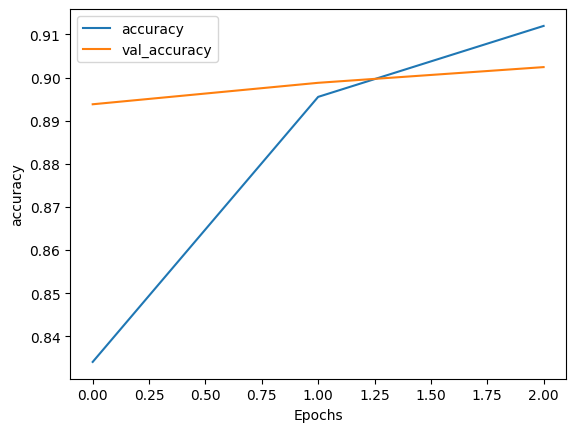

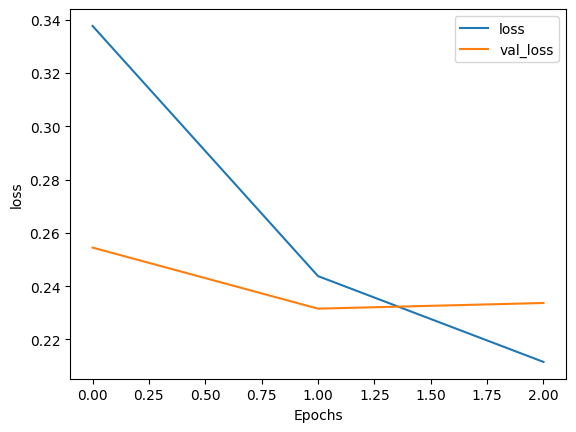

In [22]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [23]:
from sklearn.metrics import classification_report

# Generate predictions
test_predictions = model.predict(test_ids)
test_predictions = (test_predictions.flatten() > 0.5).astype(int)

# Print classification report
print(classification_report(test_labels.numpy(), test_predictions, target_names=["Not Sarcastic", "Sarcastic"]))


258/258 [==============================] - 18s 37ms/step
               precision    recall  f1-score   support

Not Sarcastic       0.89      0.93      0.91      4401
    Sarcastic       0.92      0.87      0.89      3839

     accuracy                           0.90      8240
    macro avg       0.90      0.90      0.90      8240
 weighted avg       0.90      0.90      0.90      8240

